# **Test predict LSTM and Conv**

**RELEASE**

In [1]:
REL = '_R005'

## **Importing libraries and connecting disk, global ads**

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Collecting own modules

In [3]:
import sys
sys.path.append('/gdrive/My Drive/Release/')
import Modules.global_f as mgf
import Modules.xgb_features_selector as xgbfs

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


#Функции

In [5]:
# Нормирование
def norm_df(df,  shift=1, list_rename=[], cols=[], no_cols=[]):
  df_ = df.copy()
  if cols == []:
    cols = df_.columns
  else: shift = 0
  for k in cols[shift:]:
    if k not in no_cols:
      min_ = df_[k].min()
      max_ = df_[k].max()
      if k in list_rename:
          df_['n_' + k] = df_[k].apply(lambda x: (x-min_)/(max_-min_))
      else:
          df_[k] = df_[k].apply(lambda x: (x-min_)/(max_-min_))
  return df_

In [6]:
#  Z преобразование
def z_df(df,  shift=1, list_rename=[], cols=[], no_cols=[]):
  df_ = df.copy()
  if cols == []:
    cols = df_.columns
  else: shift = 0
  for k in cols[shift:]:
    if k not in no_cols:
      _mean = df_[k].mean()
      _std = df_[k].std()
      if k in list_rename:
          df_['z_' + k] = df_[k].apply(lambda x: (x -_mean)/_std)
      else:
          df_[k] = df_[k].apply(lambda x: (x -_mean)/_std)
  return df_

In [7]:
def shift_from_end(xs, n):
    e = np.empty_like(xs)
    if n >= 0:
        e[:-n] = xs[n:]
        e[-n:] = xs[-1:]
    return e

In [8]:
def supplement(xs, n, set_adds = np.nan): # Дополняет  данные значениями set_adds с начала или с конца (+ n или - n )  
    xs = xs.flatten()
    e = np.empty(abs(n))
    e[:abs(n)] = set_adds
    if n > 0:
      e = np.append(e, xs, axis = 0)
    if n < 0:
      e = np.append(xs, e, axis = 0)
    return e

In [9]:
# Функция добавляет столбцы с ifft  в   датасет в соответствии с фильтрами list_comp_fft, возвращает датасет
def ifft_add_columns(df_, key_, list_comp_fft, n_adds =1):
  _df_ = df_.copy()
  _df_.reset_index()
  arr_big = np.array(_df_[key_]).flatten()
  arr_big = supplement(arr_big,n_adds,arr_big[0])
  arr_big = supplement(arr_big,-n_adds,arr_big[0])
  #print(arr_big.shape)
  #close_fft = np.fft.fft(np.asarray(_df_[key_].tolist()))
  close_fft = np.fft.fft(arr_big)
  fft_df = pd.DataFrame({'fft':close_fft})
  fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
  fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
  fft_list = np.asarray(fft_df['fft'].tolist())
  #print(fft_list.shape)
  for num_ in list_comp_fft:  # числа убирают из центра часточного распределения num_ компонент fft
    fft_list_filtered= np.copy(fft_list)
    fft_list_filtered[num_:-num_] = 0
    ifft_  = np.fft.ifft(fft_list_filtered)
    ifft_df = pd.DataFrame({'ifft':ifft_})
    ifft_df[key_ + '_'+ str(num_)+ '_ifft'] = ifft_df['ifft'].apply(lambda x: np.abs(x))
    ifft_df = ifft_df.drop(columns=['ifft'])
    ifft_df = ifft_df[n_adds:-n_adds].reset_index(drop = True)
    #print(ifft_df.shape)
    _df_ = pd.concat([_df_, ifft_df], axis=1)
    print(_df_.shape)
  return _df_
  

# Реализация

In [10]:
DATA_PATH = '/gdrive/My Drive/Data/' 
W_PATH = '/gdrive/My Drive/Drafts/TEST_LSTM_Conv_FTSE/'

KEY = 'FTSE 100 Historical Data_Price'#'USD_RUB Historical Data_Price'##'NYSE Composite Historical Data_Price'
GS_KEY = 'GS_Price'

In [11]:
import pandas as pd
#data = pd.read_csv(DATA_PATH + 'data_cleaner_!!clear!!_R001.csv', engine='python')  #, usecols=[1,2,3,4,5,6,7,8,9]
pd.set_option('display.max_columns', None)
df = pd.read_csv(DATA_PATH + 'df_all_scores.csv', parse_dates=[0])
df

,Date,GS_Price,GS_Open,GS_High,GS_Low,GS_Vol.,GS_Change %,GS_diffCO,GS_diffHL,FTSE 100 Historical Data_Price,FTSE 100 Historical Data_Open,FTSE 100 Historical Data_High,FTSE 100 Historical Data_Low,FTSE 100 Historical Data_Vol.,FTSE 100 Historical Data_Change %,FTSE 100 Historical Data_diffCO,FTSE 100 Historical Data_diffHL,Dow Jones Industrial Average Historical Data_Price,Dow Jones Industrial Average Historical Data_Open,Dow Jones Industrial Average Historical Data_High,Dow Jones Industrial Average Historical Data_Low,Dow Jones Industrial Average Historical Data_Vol.,Dow Jones Industrial Average Historical Data_Change %,Dow Jones Industrial Average Historical Data_diffCO,Dow Jones Industrial Average Historical Data_diffHL,S&P 500 Historical Data_Price,S&P 500 Historical Data_Open,S&P 500 Historical Data_High,S&P 500 Historical Data_Low,S&P 500 Historical Data_Change %,S&P 500 Historical Data_diffCO,S&P 500 Historical Data_diffHL,DAX Historical Data_Price,DAX Historical Data_Open,DAX Historical Data_High,DAX Historical Data_Low,DAX Historical Data_Vol.,DAX Historical Data_Change %,DAX Historical Data_diffCO,DAX Historical Data_diffHL,CAC 40 Historical Data_Price,CAC 40 Historical Data_Open,CAC 40 Historical Data_High,CAC 40 Historical Data_Low,CAC 40 Historical Data_Vol.,CAC 40 Historical Data_Change %,CAC 40 Historical Data_diffCO,CAC 40 Historical Data_diffHL,Nikkei 225 Historical Data_Price,Nikkei 225 Historical Data_Open,Nikkei 225 Historical Data_High,Nikkei 225 Historical Data_Low,Nikkei 225 Historical Data_Vol.,Nikkei 225 Historical Data_Change %,Nikkei 225 Historical Data_diffCO,Nikkei 225 Historical Data_diffHL,Shanghai Composite Historical Data_Price,Shanghai Composite Historical Data_Open,Shanghai Composite Historical Data_High,Shanghai Composite Historical Data_Low,Shanghai Composite Historical Data_Vol.,Shanghai Composite Historical Data_Change %,Shanghai Composite Historical Data_diffCO,Shanghai Composite Historical Data_diffHL,Hang Seng Historical Data_Price,Hang Seng Historical Data_Open,Hang Seng Historical Data_High,Hang Seng Historical Data_Low,Hang Seng Historical Data_Vol.,Hang Seng Historical Data_Change %,Hang Seng Historical Data_diffCO,Hang Seng Historical Data_diffHL,KOSPI Historical Data_Price,KOSPI Historical Data_Open,KOSPI Historical Data_High,KOSPI Historical Data_Low,KOSPI Historical Data_Vol.,KOSPI Historical Data_Change %,KOSPI Historical Data_diffCO,KOSPI Historical Data_diffHL,BSE Sensex 30 Historical Data_Price,BSE Sensex 30 Historical Data_Open,BSE Sensex 30 Historical Data_High,BSE Sensex 30 Historical Data_Low,BSE Sensex 30 Historical Data_Vol.,BSE Sensex 30 Historical Data_Change %,BSE Sensex 30 Historical Data_diffCO,BSE Sensex 30 Historical Data_diffHL,Bovespa Historical Data_Price,Bovespa Historical Data_Open,Bovespa Historical Data_High,Bovespa Historical Data_Low,Bovespa Historical Data_Vol.,Bovespa Historical Data_Change %,Bovespa Historical Data_diffCO,Bovespa Historical Data_diffHL,S&P Merval Historical Data_Price,S&P Merval Historical Data_Open,S&P Merval Historical Data_High,S&P Merval Historical Data_Low,S&P Merval Historical Data_Change %,S&P Merval Historical Data_diffCO,S&P Merval Historical Data_diffHL,CBOE Volatility Index Historical Data_Price,CBOE Volatility Index Historical Data_Open,CBOE Volatility Index Historical Data_High,CBOE Volatility Index Historical Data_Low,CBOE Volatility Index Historical Data_Change %,CBOE Volatility Index Historical Data_diffCO,CBOE Volatility Index Historical Data_diffHL,MOEX Russia Historical Data_Price,MOEX Russia Historical Data_Open,MOEX Russia Historical Data_High,MOEX Russia Historical Data_Low,MOEX Russia Historical Data_Change %,MOEX Russia Historical Data_diffCO,MOEX Russia Historical Data_diffHL,Bitcoin Historical Data_Price,Bitcoin Historical Data_Open,Bitcoin Historical Data_High,Bitcoin Historical Data_Low,Bitcoin Historical Data_Vol.,Bitcoin Historical Data_Change %,Bitcoin Historical Data_diffCO,Bitcoin Historical Data_di

In [12]:
# cols_to_work =['Date', KEY, 'Bitcoin Historical Data_Price', 'USD_JPY Historical Data_Price', 'GBP_USD Historical Data_Price',
#                'Brent Oil Futures Historical Data_Price', 'EUR_USD Historical Data_Price',   'Dow Jones Basic Materials Historical Data_Price', 
#                'NYSE Energy Historical Data_Price', 'S&P 500 Materials Historical Data_Price', 'S&P 500 Real Estate Historical Data_Price'] 
# #'LIBOR USD_ON' ,  'LIBOR USD_1W' ,  'LIBOR USD_1M' , 'LIBOR USD_2M', 'LIBOR USD_3M', 'LIBOR USD_6M', 'LIBOR USD_12M',

In [13]:
df = df.interpolate(method ='linear', limit_direction ='both', limit = 50)

In [14]:
#cols = ['Date', KEY] + list(best_features_z.columns) +['d1', 'd2', 'd3']#list(best_features_n.columns)
cols = ['Date', KEY]   + ['sentiment score',	'bull score',	'bear score']  #list(best_features_n.columns)  ['sentiment score',	'bull score',	'bear score'] 
cols

['Date',
 'FTSE 100 Historical Data_Price',
 'sentiment score',
 'bull score',
 'bear score']

In [15]:
data = df[cols]
mask = (data['Date'] <='2021-03-01') 
data = data.loc[mask]
data.info()
data  = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            2482 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price  2482 non-null   float64       
 2   sentiment score                 2482 non-null   float64       
 3   bull score                      2482 non-null   float64       
 4   bear score                      2482 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 116.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            2482 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price  2482 non-n

In [16]:
_std =data[KEY].std()
_mean = data[KEY].mean()
_min = data[KEY].min()
_max = data[KEY].max()
_mean, _std, _max, _min

(6612.7862852538265, 652.3861607839629, 7877.45, 4944.44)

In [17]:
zn_train_df = z_df(data, 1, [KEY, 'Date'])#, no_cols=['d1', 'd2'])
zn_train_df.info()
z_y_key = 'z_'+KEY
z_y_key

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              2482 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price    2482 non-null   float64       
 2   sentiment score                   2482 non-null   float64       
 3   bull score                        2482 non-null   float64       
 4   bear score                        2482 non-null   float64       
 5   z_FTSE 100 Historical Data_Price  2482 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 135.7 KB


'z_FTSE 100 Historical Data_Price'

In [18]:
# f_cols = ['price','sentiment score','bull score', 'bear score']
#ifft_cols = list(best_features_z.columns) +['d1', 'd2', 'd3']#[]#['sentiment score','bull score', 'bear score']+ ['d1', 'd2'] 
ifft_cols =  [z_y_key, 'sentiment score',	'bull score',	'bear score'] # ['sentiment score','bull score', 'bear score'] 
list_fft_comp = [16, 64]
key_for_d =  z_y_key + '_' + str(max(list_fft_comp)) + '_ifft'
key_for_d

'z_FTSE 100 Historical Data_Price_64_ifft'

In [19]:
for key_ in ifft_cols:  
   zn_train_df = ifft_add_columns(zn_train_df, key_, list_fft_comp, n_adds =1000)
zn_train_df = zn_train_df.drop(columns=ifft_cols)
zn_train_df.info()

(2482, 7)
(2482, 8)
(2482, 9)
(2482, 10)
(2482, 11)
(2482, 12)
(2482, 13)
(2482, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      2482 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price            2482 non-null   float64       
 2   z_FTSE 100 Historical Data_Price_16_ifft  2482 non-null   float64       
 3   z_FTSE 100 Historical Data_Price_64_ifft  2482 non-null   float64       
 4   sentiment score_16_ifft                   2482 non-null   float64       
 5   sentiment score_64_ifft                   2482 non-null   float64       
 6   bull score_16_ifft                        2482 non-null   float64       
 7   bull score_64_ifft                        2482 non-null   float64       
 8   bear score_16_ifft     

In [20]:
zn_train_df['d1'] = (shift_from_end(zn_train_df[key_for_d],1)-zn_train_df[key_for_d])
zn_train_df['d2'] =(shift_from_end(zn_train_df['d1'],1)-zn_train_df['d1'])
#zn_train_df['d3'] =(shift_from_end(zn_train_df['d2'],1)-zn_train_df['d2'])
zn_train_df = z_df(zn_train_df, cols=['d1', 'd2'])#, 'd3'])

In [21]:
for key_ in ['d1', 'd2']:  
   zn_train_df = ifft_add_columns(zn_train_df, key_, list_fft_comp, n_adds =1000)
zn_train_df = zn_train_df.drop(columns=['d1', 'd2'])

(2482, 13)
(2482, 14)
(2482, 15)
(2482, 16)


In [22]:
#zn_train_df = z_df(zn_train_df, 1, [KEY, 'Date'])#, no_cols=['d1', 'd2'])
zn_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      2482 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price            2482 non-null   float64       
 2   z_FTSE 100 Historical Data_Price_16_ifft  2482 non-null   float64       
 3   z_FTSE 100 Historical Data_Price_64_ifft  2482 non-null   float64       
 4   sentiment score_16_ifft                   2482 non-null   float64       
 5   sentiment score_64_ifft                   2482 non-null   float64       
 6   bull score_16_ifft                        2482 non-null   float64       
 7   bull score_64_ifft                        2482 non-null   float64       
 8   bear score_16_ifft                        2482 non-null   float64       
 9   bear score_64_ifft            

In [23]:
zn_train_df['y'] = (zn_train_df[KEY]-_mean)/_std
#zn_train_df = zn_train_df.drop(columns=[z_y_key])

In [24]:
zn_train_df

,Date,FTSE 100 Historical Data_Price,z_FTSE 100 Historical Data_Price_16_ifft,z_FTSE 100 Historical Data_Price_64_ifft,sentiment score_16_ifft,sentiment score_64_ifft,bull score_16_ifft,bull score_64_ifft,bear score_16_ifft,bear score_64_ifft,d1_16_ifft,d1_64_ifft,d2_16_ifft,d2_64_ifft,y
0,2011-04-19,5896.87,1.257537,1.056873,0.205572,0.292163,0.112105,0.337265,0.379951,0.255314,0.382491,0.116831,0.006378,0.080043,-1.097381
1,2011-04-20,6022.26,1.261881,1.058442,0.205286,0.293134,0.103366,0.315194,0.383321,0.249386,0.382638,0.101688,0.006637,0.082843,-0.905179
2,2011-04-21,6018.30,1.266232,1.059974,0.205089,0.294680,0.094651,0.292321,0.386686,0.242686,0.382711,0.086087,0.006897,0.085072,-0.911249
3,2011-04-25,6043.83,1.270589,1.061450,0.204982,0.296800,0.085977,0.268678,0.390044,0.235214,0.382713,0.070276,0.007158,0.086692,-0.872116
4,2011-04-26,6069.36,1.274952,1.062851,0.204965,0.299487,0.077367,0.244299,0.393395,0.226976,0.382641,0.054659,0.007421,0.087666,-0.832983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,2021-02-23,6625.94,0.529621,0.499647,0.296051,0.472551,0.667774,0.930628,0.351538,0.626503,0.063788,1.420225,0.003935,0.213604,0.020162
2478,2021-02-24,6658.97,0.531797,0.531714,0.287730,0.433202,0.670009,0.910207,0.352450,0.611465,0.063646,1.379477,0.003882,0.240025,0.070792
2479,2021-02-25,6651.96,0.534093,0.563286,0.279379,0.393376,0.672195,0.889441,0.353346,0.595857,0.063574,1.333344,0.003832,0.264596,0.060047
2480,2021-02-26,6483.43,0.536507,0.594290,0.270999,0.353198,0.674330,0.868433,0.354228,0.579758,0.063572,1.282204,0.003784,0.287189,-0.198282


In [25]:
zn_train_df.info(max_cols=600)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   Date                                      2482 non-null   datetime64[ns]
 1   FTSE 100 Historical Data_Price            2482 non-null   float64       
 2   z_FTSE 100 Historical Data_Price_16_ifft  2482 non-null   float64       
 3   z_FTSE 100 Historical Data_Price_64_ifft  2482 non-null   float64       
 4   sentiment score_16_ifft                   2482 non-null   float64       
 5   sentiment score_64_ifft                   2482 non-null   float64       
 6   bull score_16_ifft                        2482 non-null   float64       
 7   bull score_64_ifft                        2482 non-null   float64       
 8   bear score_16_ifft                        2482 non-null   float64       
 9   bear score_64_ifft            

In [26]:
window = 64
f = 32

In [27]:
x = []
i = 0
while window + i + 1  < zn_train_df.shape[0]:
    df_x = zn_train_df.iloc[i:window+i, 2:zn_train_df.shape[1]].reset_index(drop = 1)# - ntrain_df.iloc[i:window +i, 2:].reset_index(drop = 1)
    x.append(df_x.to_numpy())
    i += 1
x = np.array(x)
x.shape

(2417, 64, 13)

In [28]:
x_c = np.reshape(x, (-1, x.shape[1], x.shape[2], 1))
x_l = np.reshape(x, (-1, x.shape[1], x.shape[2]))
x_c.shape, x_l.shape

((2417, 64, 13, 1), (2417, 64, 13))

## Пробуем LSTM

In [29]:
N = 2380 # разбиваем на train и val 

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.models import Sequential, Model

In [31]:
lstm = Sequential(name="LSTM")
lstm.add(LSTM(1024, recurrent_regularizer='L2' , input_shape = (x.shape[1], x.shape[2]), return_sequences="True"))
lstm.add(LSTM(1024, recurrent_regularizer='L2')) #, return_sequences="True"))
#model.add(Conv1D(64, 3, activation="linear"))
# model.add(Conv1D(64, 3, activation="linear"))
# model.add(Flatten())
# model.add(Dense(16, activation="linear"))
lstm.add(Dense(f, activation="linear"))

lstm.compile(loss="mae", optimizer="adam", metrics=['mae'])
lstm.summary()


Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 1024)          4251648   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dense (Dense)                (None, 32)                32800     
Total params: 12,677,152
Trainable params: 12,677,152
Non-trainable params: 0
_________________________________________________________________


In [35]:
lstm.load_weights(W_PATH + 'lstm_FTSE2_070121_1000_3_1024_1024_y_ifft16-64(snt+y+d1+d2)_16-32_0.07542631030082703')

# Пробуем discriminator

In [36]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(x.shape[1], x.shape[2], 1)),
        layers.Conv2D(512, (9, 9), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (7, 7), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (3, 3), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(f, (3, 3), strides=(1, 1), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 13, 512)       41984     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 13, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 13, 256)       6422784   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 13, 256)       590080    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 13, 32)      

In [37]:
discriminator.compile(loss="mae", optimizer="adam", metrics=['mae'])

In [38]:
discriminator.load_weights(W_PATH + 'disc_FTSE2_070121_1000_3_1024_1024_y_ifft16-64(snt+y+d1+d2)_16-32_0.10152037441730499')

In [39]:
def add_shift(xs, n):
    xs = xs.flatten()
    e = np.empty(n)
    e[:n] = np.nan 
    if n >= 0:
        e = np.append(e, xs, axis = 0)
    return e

In [41]:
# Напоминалка
x_c.shape, data.shape, window, f, np.array(df[KEY]).shape, np.array(df[KEY]).shape[0] - window

((2417, 64, 13, 1), (2482, 5), 64, 32, (2516,), 2452)

# График предсказания

In [42]:
N = 2250  # старт отображения в масштабе x (сдвиг на window)
K = zn_train_df.shape[0]
pred = discriminator.predict(x_c[N:K])* _std + _mean #* (_max - _min) + _min
pred2 = lstm.predict(x_l[N:K])* _std + _mean
pred.shape, pred2.shape
Y = np.array(df[KEY][window + N +1:])#window + K:])# + 2:])#window + K + 2])

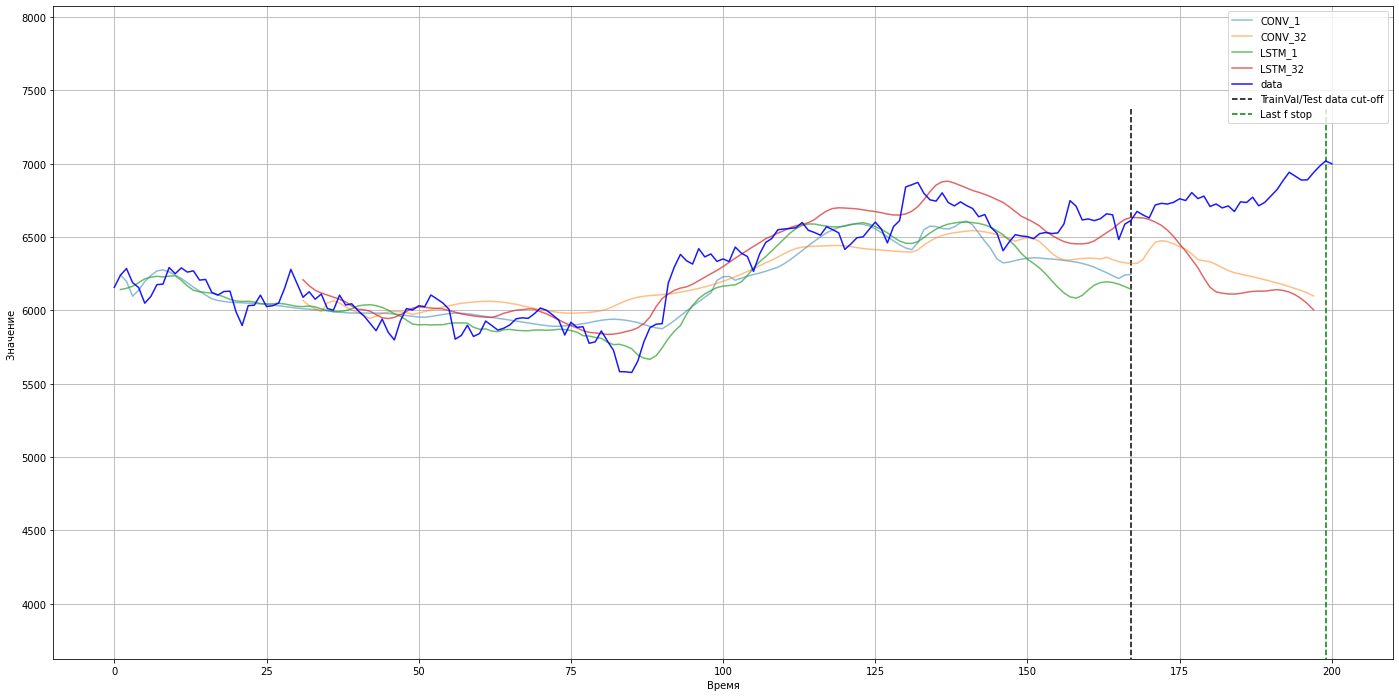

In [44]:
plt.figure(figsize=(24,12))
plt.grid('on')

plt.plot(add_shift(pred[:,0:1],1), label='CONV_1', alpha = 0.5)
# plt.plot(add_shift(pred[:,1:2],2), label='CONV_2', alpha = 0.5)
# plt.plot(add_shift(pred[:,2:3],3), label='CONV_3', alpha = 0.5)
plt.plot(add_shift(pred[:,31:32],31), label='CONV_32', alpha = 0.5)

plt.plot(add_shift(pred2[:,0:1],1), label='LSTM_1', alpha = 0.7)
# plt.plot(add_shift(pred2[:,1:2],2), label='LSTM_2', alpha = 0.7)
# plt.plot(add_shift(pred2[:,2:3],3), label='LSTM_3', alpha = 0.7)
plt.plot(add_shift(pred2[:,31:32],31), label='LSTM_32', alpha = 0.7)

plt.plot(Y, label='data', alpha =0.9, color = 'blue')
#plt.plot(y_plot, label='y_plot', alpha =1, color = 'red')

# plt.plot(add_shift(pred_yf_cov[:,0:1],  x_c.shape[0]-N), label='CONV_1_xf', alpha = 0.5)
# plt.plot(add_shift(pred_yf_cov[:,31:32],  x_c.shape[0]-N+f), label='CONV_32_xf', alpha = 0.5)

# plt.plot(add_shift(pred2_yf[:,0:1], x_l.shape[0]-N), label='lstm_1_xf', alpha = 0.5)
# plt.plot(add_shift(pred2_yf[:,31:32], x_l.shape[0]-N+f), label='lstm_32_xf', alpha = 0.5)

plt.vlines(zn_train_df.shape[0]-N-1-window, 1.05*Y.max(), 0, linestyles='--', label='TrainVal/Test data cut-off', color = 'black')
plt.vlines(zn_train_df.shape[0]-N-1-window +f , 1.05*Y.max(), 0, linestyles='--', label='Last f stop', color = 'green')

plt.xlabel('Время')
plt.ylabel('Значение ')

plt.ylim([0.65*Y.min(), 1.15*Y.max()])

plt.legend()
plt.show()